## Multi Agent Work Flow

In [140]:
# imports 

from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langgraph.graph import StateGraph, START,END,add_messages, MessagesState
from langgraph.graph.state import CompiledGraph
from langgraph.graph.message import add_messages
from typing_extensions import Annotated
from typing import TypedDict
from langchain_community.tools import TavilySearchResults
import os
import getpass


def _set_if_undifined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Provide your keys {var}")

_set_if_undifined("GEMINI_API_KEY")
_set_if_undifined("TAVILY_API_KEY")

In [141]:
api_key = os.getenv("GEMINI_API_KEY")

llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash", api_key=api_key)

In [142]:
# Define Tools
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool, Tool
from langchain_experimental.utilities import PythonREPL
from typing import Dict
from langchain_community.retrievers import TavilySearchAPIRetriever

# retriever = TavilySearchAPIRetriever(max=5)


# first define the tavil search 

# tavily_search = TavilySearchResults(max=5)
GDP_DATABASE = {
    "2019": 2.831,
    "2020": 2.709,
    "2021": 3.187,
    "2022": 3.070,
    "2023": 3.141
}

def search_gdp_data() -> Dict[str, float]:
    """
    A simple function to return UK GDP data from our mock database
    """
    return GDP_DATABASE

custom_research_tool = Tool(
    name="uk_gdp_search",
    description="Searches for UK GDP data over the past 5 years",
    func=search_gdp_data
)



# Now initialize the python repl
# python_repl = PythonREPL()
python_repl = PythonREPL()


# Now Define the python tool that will generate the image or chart of the research data

@tool
def python_tool(code: Annotated[str, "The python code to execute to generate your chart."],):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""

    try: 
        result = python_repl.run(("import matplotlib.pyplot as plt\nimport numpy as np"))
    except Exception as e:
        return f"Falied to execute {e} "
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    # This line will tell llm if you completed the task than go to final ans
    return (result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER.")


In [143]:
# Create graph
# Now that we've defined our tools and made some helper functions, will create the individual agents below and tell them how to talk to each other using LangGraph.

# but before going to create the graph first we have to create some utilities like prompt templates

# this is a system prompt
def make_system_prompt(suffix: str) -> str:
    return (
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, another assistant with different tools "
        " will help where you left off. Execute what you can to make progress."
        " If you or any of the other assistants have the final answer or deliverable,"
        " prefix your response with FINAL ANSWER so the team knows to stop."
        f"\n{suffix}"
    )



In [144]:
from langchain_core.messages import BaseMessage
from langgraph.prebuilt import create_react_agent
from langgraph.types import Command
from typing import Literal
from time import sleep
from tenacity import retry, wait_exponential

# Ok Now Start To Construct the nodes

# first create the next node so the llm knows where to go next

def get_next_node(last_message: BaseMessage, goto: str):
    if "FINAL_ANSWER" in last_message.content:
        return END
    return goto

# Now create the Research agent and his node
# get create_react_agent from the prebuilt tool


research_agent = create_react_agent(
    llm,
    tools=[custom_research_tool],
   state_modifier=make_system_prompt(
        "You are a research agent with access to UK GDP data. "
        "When asked about UK GDP, use the uk_gdp_search tool to retrieve the data "
        "and format it for your chart generator colleague. "
        "Present the data in a clear year: value format."
    ),
)

# Ok Now After creating the Research Agent its a good time to create research node

def research_node(state: MessagesState) -> Command[Literal["chat_generator",END]]:

    result = research_agent.invoke(state)
    # result = rate_limited_invoke(research_agent, state)
    goto = get_next_node(result["messages"][-1], "chat_generator")

    # ok Now wrap the AI Message to Human Message so it will send to next Agent
    result["messages"][-1] = HumanMessage(content=result["messages"][-1].content, name="researcher")

    # return Command({
    # "update": {"messages": result["messages"]},
    # "goto": goto
    # })

    return Command(
        update={
            # share internal message history of chart agent with other agents
            "messages": result["messages"],
        },
        goto=goto,
    )

# Ok Now Start To Create Next Agent Which is a Chat Agent

chat_agent = create_react_agent(
    llm,
    tools=[python_tool],
      state_modifier=make_system_prompt(
        "You are a chart generation agent. When you receive GDP data, create clear "
        "visualizations using matplotlib. Always start by running the necessary imports. "
        "Create professional-looking charts with proper labels and titles."
    ),
)



# Now Create its node

def chat_node(state: MessagesState) -> Command[Literal["researcher", END]]:
    result = chat_agent.invoke(state)
    # result = rate_limited_invoke(research_agent, state)
    goto = get_next_node(result["messages"][-1],"researcher")

    # Again Same sa research wrap the text

    result["messages"][-1] = HumanMessage(content=result["messages"][-1].content, name="chat_generator")

    return Command(
        update={
            # share internal message history of chart agent with other agents
            "messages": result["messages"],
        },
        goto=goto,
    )
   




C:\Users\wtc\AppData\Local\Temp\ipykernel_868\3797014353.py:21: LangGraphDeprecationWarning: Parameter 'messages_modifier' in function 'create_react_agent' is deprecated as of version 0.1.9 and will be removed in version 0.3.0. Use 'state_modifier' parameter instead.
  research_agent = create_react_agent(
C:\Users\wtc\AppData\Local\Temp\ipykernel_868\3797014353.py:67: LangGraphDeprecationWarning: Parameter 'messages_modifier' in function 'create_react_agent' is deprecated as of version 0.1.9 and will be removed in version 0.3.0. Use 'state_modifier' parameter instead.
  chat_agent = create_react_agent(


In [137]:
# OK Now Create The Graph

builder = StateGraph(MessagesState)

builder.add_node("researcher",research_node)
builder.add_node("chat_generator",chat_node)

builder.add_edge(START, "researcher")

graph: CompiledGraph = builder.compile()


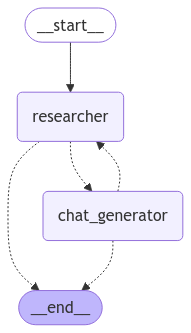

In [138]:
# Image
from IPython.display import Image

Image(graph.get_graph().draw_mermaid_png())

In [139]:
events = graph.stream(
    {
        "messages": [
            (
                "user",
                "Get the simple any data from internet so the values will use for creating chart"
                "Once you make the chart, finish.",
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 10},
)
for s in events:
    print(s)
    print("----")

{'researcher': {'messages': [HumanMessage(content='Get the simple any data from internet so the values will use for creating chartOnce you make the chart, finish.', additional_kwargs={}, response_metadata={}, id='0294e85c-bc5f-41d3-bb95-b435028e2237'), AIMessage(content='', additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': '{"query": "Global population growth"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-f81ed651-d870-487e-9c86-5a035c3a5593-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Global population growth'}, 'id': '80b35916-b0b3-44de-ab96-c588a38c0bed', 'type': 'tool_call'}], usage_metadata={'input_tokens': 208, 'output_tokens': 12, 'total_tokens': 220, 'input_token_details': {'cache_read': 0}}), ToolMessage(content='[{"url": "https://en.wikipedia.org/wiki/Population_growth", "content": "Population growth rate (2023, Our

GraphRecursionError: Recursion limit of 10 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT

In [131]:
tavily_search.invoke("Get the simple any data from internet so the values will use for creating chart")

[{'url': 'https://whatsoftware.com/easily-create-charts-online-without-using-excel-or-any-software/',
  'content': 'Most aspects of creating the chart can be configured like colors, labels and orientation etc, and ChartGizmo supports several data sources that include static data, historical data and dynamic data from a HTML table. You can also use the Import button to paste in tab-delimited data or values from an Excel sheet. There are various ways to get'},
 {'url': 'https://chart-studio.plotly.com/create/',
  'content': 'Create charts and graphs online with Excel, CSV, or SQL data. Make bar charts, histograms, box plots, scatter plots, line graphs, dot plots, and more. Free to get started! Make charts and dashboards online from CSV or Excel data. Create interactive D3.js charts, reports, and dashboards online.'},
 {'url': 'https://apexcharts.com/graph-maker/',
  'content': "Plenty of chart templates to get started. Select from templates or start from scratch. ... DRAG AND DROP. Chart